# TP 2: Simple neural networks

## Part 1: Implement your own Multi-Layer Perceptron (MLP) and vanilla Convolutional Neural Network (CNN) on FashionMNIST data

Help:
- https://pytorch.org/tutorials/beginner/basics/intro.html
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

### 1. Load useful packages

Some of the modules will be imported only when required. But obviously, it is clearer to put these imports at the beginning of your scripts.

In [1]:
import scipy # scientific computing library
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models

import os

import torch

Check the version of Pytorch

In [2]:
torch.__version__

'2.6.0.dev20240917'

To execute the code on Google Collab go to tab Runtime > Change runtime type. Select GPU in Hardware accelerator

#### Set device

Check if you can use a GPU

In [3]:
torch.cuda.is_available()

False

In [4]:
torch.cuda.device_count()

0

Choose the device

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" #0 indicates the GPU you gonna use
print(f"Using {device} device")

Using cpu device


##### Manage GPU usage

From a terminal, you can launch the following command to manage GPU ressources, allocation between different users...

```bash
watch -n1 nvidia-smi
```
```-n``` means every second it is updated.

### 2. Load and preprocess the Fashion-MNIST dataset

Fashion-MNIST is a [dataset](https://github.com/zalandoresearch/fashion-mnist) of Zalando's article images—consisting of 60,000 28x28 grayscale training images of 10 fashion categories (Tshirt, Trouser, Pullover, Dress, Coat, Sandal, Shift, Sneaker, Bag, Ankle boot), along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST.

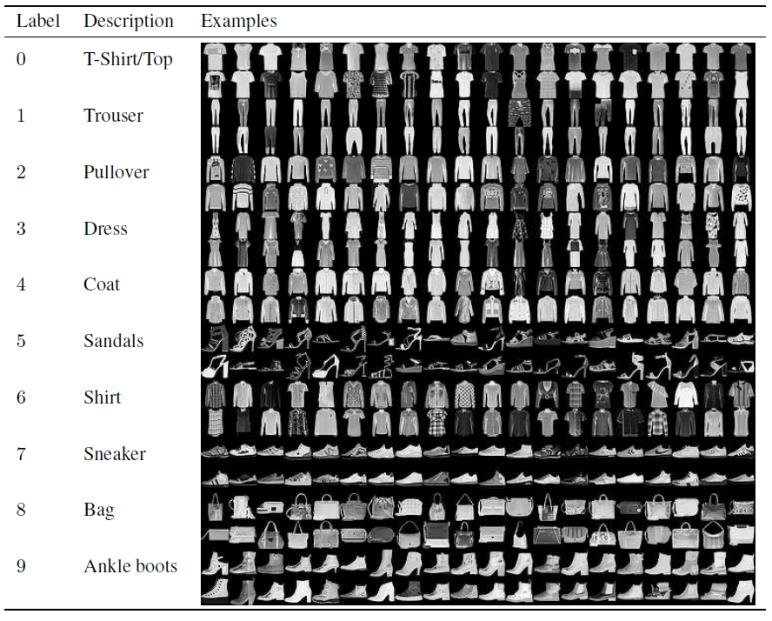

The data can be directly downloaded with PyTorch. Please visit the following website: https://pytorch.org/vision/stable/datasets.html

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

Download training (argument `train=True`) and test (argument `train=False`) data from open datasets. Don't forget to set the `transformation`.

In [7]:
import os
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, random_split
from torch.utils.data import DataLoader
root_dir=os.getcwd()

# Définir les transformations
transform = transforms.Compose([transforms.ToTensor()])

# Télécharger les ensembles d'entraînement et de test
train_dataset = datasets.FashionMNIST(root=root_dir, train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=root_dir, train=False, download=True, transform=transform)

# Définir la taille des ensembles
total_size = len(train_dataset)
train_size = int(0.9 * total_size)  # 90% pour l'entraînement
validation_size = int(0.1 * total_size)  # 10% pour la validation

# Diviser les données en ensembles d'entraînement, de validation et de test
train_dataset, validation_dataset = random_split(
    train_dataset, [train_size, validation_size]
)

Convert to dataloader

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Visualize the data

images.shape: torch.Size([64, 1, 28, 28])


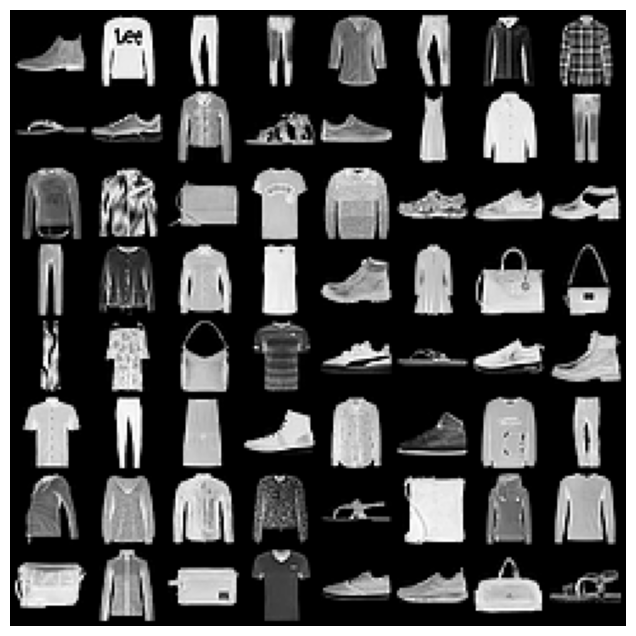

In [9]:
from torchvision.utils import make_grid
for images, _ in test_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

### 3. Implement and train a fully-connected NN model with 2 layers

Help:

- check all possible methods to set your network architecture: https://pytorch.org/docs/stable/nn.html
  - [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)
  - [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
  - [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
  - [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax)
  - [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
- check various optimization algorithms: https://pytorch.org/docs/stable/optim.html


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        self.batch1 = nn.BatchNorm1d(784) 
        self.dense1 = nn.Linear(784, 256)
        
        self.batch2 = nn.BatchNorm1d(256) 
        self.dense2 = nn.Linear(256, 64)
        
        self.batch3 = nn.BatchNorm1d(64) 
        self.dense3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        
        x = self.batch1(x)
        x = self.dense1(x)
        x = F.relu(x)
        
        x = self.batch2(x)
        x = self.dense2(x)
        x = F.relu(x)
        
        x = self.batch3(x)
        x = self.dense3(x)
        return x

Initialize the model

In [11]:
def trainModel(model, criterion, optimizer, dataset):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, (inputs, labels) in enumerate(dataset):
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = running_loss / len(dataset)
    return accuracy, average_loss

In [12]:
def ValidatModel(model, criterion, optimizer, dataset):
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    for data in dataset:
        inputs, labels = data
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_running_loss += loss.item()
        
        _, val_predicted = torch.max(outputs.data, 1)
        val_total += labels.size(0)
        val_correct += (val_predicted == labels).sum().item()
        
    val_accuracy = val_correct / val_total
    val_average_loss = val_running_loss / len(dataset)
    
    return val_accuracy,val_average_loss

In [16]:
from torch.utils.tensorboard import SummaryWriter
import time
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim 

def findBestLearninRate(model):
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
    lambda1 = lambda epoch: 10**(epoch/10)
    scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])

    tabLearningRate=[]
    tabLoss=[]

    epoch=0
    while(optimizer.param_groups[0]["lr"]<1 and optimizer.param_groups[0]["lr"]!= None):
        accuracy, average_loss = trainModel(model, criterion, optimizer, train_loader)
        scheduler.step()

        tabLearningRate+= [optimizer.param_groups[0]["lr"]]
        tabLoss+=[average_loss]


        print(f'Epoch {epoch} - '
              f'Accuracy: {accuracy:.4f} - '
              f'Average Loss: {average_loss:.4f} - '
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:}')
        epoch+=1
    return tabLearningRate, tabLoss

tabLearningRate, tabLoss = findBestLearninRate(Net())

Epoch 0 - Accuracy: 0.4512 - Average Loss: 1.7732 - Learning Rate: 1.2589254117941673e-05
Epoch 1 - Accuracy: 0.6573 - Average Loss: 1.2803 - Learning Rate: 1.5848931924611138e-05
Epoch 2 - Accuracy: 0.7155 - Average Loss: 1.0815 - Learning Rate: 1.9952623149688796e-05
Epoch 3 - Accuracy: 0.7467 - Average Loss: 0.9461 - Learning Rate: 2.5118864315095805e-05
Epoch 4 - Accuracy: 0.7685 - Average Loss: 0.8441 - Learning Rate: 3.1622776601683795e-05
Epoch 5 - Accuracy: 0.7891 - Average Loss: 0.7564 - Learning Rate: 3.981071705534973e-05
Epoch 6 - Accuracy: 0.8027 - Average Loss: 0.6847 - Learning Rate: 5.0118723362727224e-05
Epoch 7 - Accuracy: 0.8146 - Average Loss: 0.6247 - Learning Rate: 6.309573444801933e-05
Epoch 8 - Accuracy: 0.8245 - Average Loss: 0.5716 - Learning Rate: 7.943282347242817e-05
Epoch 9 - Accuracy: 0.8347 - Average Loss: 0.5284 - Learning Rate: 0.0001
Epoch 10 - Accuracy: 0.8419 - Average Loss: 0.4902 - Learning Rate: 0.00012589254117941674
Epoch 11 - Accuracy: 0.8517 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


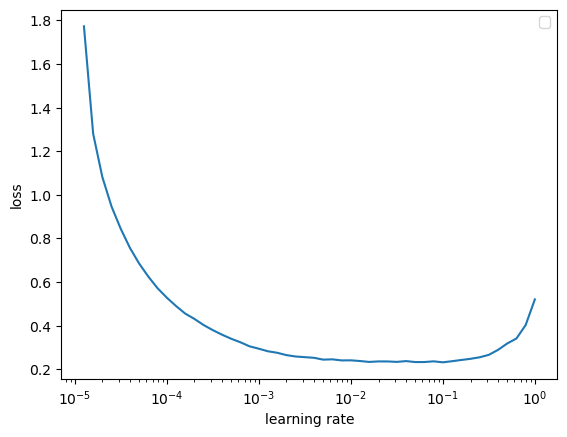

best LearningRate: 0.1


In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(tabLearningRate, tabLoss)
plt.xlabel('learning rate')
plt.xscale('log')
plt.ylabel('loss')
plt.legend()

plt.show()

min_y = min(tabLoss)
min_index = tabLoss.index(min_y)

LearningRate = tabLearningRate[min_index]
print('best LearningRate:',LearningRate)
#best LearningRate: 0.0008912509381337458

Set the loss function and the optimizer

Set the training loop and launch the training

In [18]:
from torch.utils.tensorboard import SummaryWriter
import time

def trainAlgo(train_generator,validation_generator,model,criterion,optimizer ,LearningRate):
    #LearningRate = 0.0316227766016838
    num_epochs=1

    bestLoss_Loss = 100
    bestAccuracy_Loss = 0

    lossCount = 0
    accuracyCount = 0

    writer = SummaryWriter()

    epoch = 0

    epoch_best_loss = 0
    epoch_best_accuracy = 0
    #for epoch in range(num_epochs):
    # Boucle d'entraînement

    writer = SummaryWriter()
    while True:
        epoch = epoch + 1
        model.train()
        start_time = time.time()
        accuracy_train, loss_train = trainModel(model, criterion, optimizer, train_generator)
        epoch_time_train = time.time() - start_time

        # Ajouter les métriques à TensorBoard
        writer.add_scalar('Loss/train', loss_train, epoch)
        writer.add_scalar('Accuracy/train', accuracy_train, epoch)

        # Mettre le modèle en mode évaluation
        model.eval()
        with torch.no_grad():
            start_time = time.time()
            accuracy_val,loss_val = ValidatModel(model, criterion, optimizer, validation_generator)

            if loss_val < bestLoss_Loss: #10 fois
                print("new best model")
                bestLoss_Loss = loss_val
                bestAccuracy_Loss = accuracy_val
                epoch_best_loss = epoch
                torch.save(model.state_dict(), 'best_model_original_loss.pth')
                # save torche model loss
                lossCount = 0
            else :
                lossCount += 1

            if lossCount > 20:
                break

            epoch_time_val = time.time() - start_time

            writer.add_scalar('Loss/val', loss_val, epoch)
            writer.add_scalar('Accuracy/val', accuracy_val, epoch)

            print(f'Epoch {epoch+1} - '
            f'Loss: {loss_train:.4f} - Accuracy: {accuracy_train:.4f} - '
            f'Time: {epoch_time_train:.2f} seconds - '
            f'Val Loss: {loss_val:.4f} - Val Accuracy: {accuracy_val:.4f} - '
            f'Time: {epoch_time_val:.2f} seconds')
    writer.close()
    return bestLoss_Loss, bestAccuracy_Loss
    
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LearningRate)
bestLoss_Loss, bestAccuracy_Loss = trainAlgo(train_loader,validation_loader,model,criterion,optimizer ,LearningRate)

new best model
Epoch 2 - Loss: 0.4521 - Accuracy: 0.8374 - Time: 5.14 seconds - Val Loss: 0.3767 - Val Accuracy: 0.8580 - Time: 0.38 seconds
new best model
Epoch 3 - Loss: 0.3459 - Accuracy: 0.8726 - Time: 5.73 seconds - Val Loss: 0.3367 - Val Accuracy: 0.8730 - Time: 0.41 seconds
new best model
Epoch 4 - Loss: 0.3051 - Accuracy: 0.8870 - Time: 5.18 seconds - Val Loss: 0.3073 - Val Accuracy: 0.8880 - Time: 0.50 seconds
Epoch 5 - Loss: 0.2805 - Accuracy: 0.8950 - Time: 5.55 seconds - Val Loss: 0.3318 - Val Accuracy: 0.8768 - Time: 0.37 seconds
Epoch 6 - Loss: 0.2626 - Accuracy: 0.9013 - Time: 4.99 seconds - Val Loss: 0.3084 - Val Accuracy: 0.8872 - Time: 0.41 seconds
Epoch 7 - Loss: 0.2458 - Accuracy: 0.9066 - Time: 5.74 seconds - Val Loss: 0.3197 - Val Accuracy: 0.8850 - Time: 0.38 seconds
Epoch 8 - Loss: 0.2330 - Accuracy: 0.9127 - Time: 4.87 seconds - Val Loss: 0.3335 - Val Accuracy: 0.8822 - Time: 0.36 seconds
Epoch 9 - Loss: 0.2186 - Accuracy: 0.9166 - Time: 4.49 seconds - Val Loss

Evaluate on the test set

In [34]:
#meilleur modèle (loss) : best_model_loss.pth
#model.load_state_dict(torch.load('best_model_loss.pth'))

print("Model loss : ")
print("loss :")
print(bestLoss_Loss)
print("accuracy :")
print(bestAccuracy_Loss)


model.load_state_dict(torch.load('best_model_original_loss.pth'))

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal','Shirt','Sneaker','Bag', 'Ankle boot')

def AccurancyByClass(model,classes,validation_loader):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in validation_loader:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

AccurancyByClass(model,classes,validation_loader)

Model loss : 
loss :
0.24133190809887775
accuracy :
0.915


/var/folders/5g/lb5rqdn537gdsvb2ylrqtblm0000gn/T/ipykernel_15170/2584451427.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

Accuracy for class: T-shirt/top is 86.3 %
Accuracy for class: Trouser is 98.3 %
Accuracy for class: Pullover is 79.1 %
Accuracy for class: Dress is 91.6 %
Accuracy for class: Coat  is 91.1 %
Accuracy for class: Sandal is 98.3 %
Accuracy for class: Shirt is 79.6 %
Accuracy for class: Sneaker is 95.3 %
Accuracy for class: Bag   is 98.4 %
Accuracy for class: Ankle boot is 97.6 %


How to save the model? <br>
Help: https://pytorch.org/tutorials/beginner/saving_loading_models.html


In [36]:
import torch

def accurancyTest(test_loader):
    correct = 0
    total = 0

    # Supposons que test_loader soit votre DataLoader pour les données de test
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data  # Charger les inputs et labels depuis test_loader
            outputs = model(inputs)

            # La classe avec la plus haute probabilité est choisie comme prédiction
            _, predicted = torch.max(outputs.data, 1)

            # Vérification que labels est un tenseur, pas un entier
            if isinstance(labels, torch.Tensor):
                total += labels.size(0)  # labels.size(0) donne la taille du batch
                correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total} %')
accurancyTest(test_loader)

Accuracy of the network on the test images: 91.24 %


#### Steps further

1. Monitor your training:

  a) Use a validation set
  - define a validation set
  - use it to evaluate the model at each epoch
  - only evaluate on the test set at the end of the training

  b) Use a external tool to visualize statistics on real-time: tensorboard

2. Try to adjust the network architecture and use regularization such as Dropout, BatchNormalization /!\ order


### 4. Implement and train a LeNet model

Help:
- [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d)


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Utiliser 1 comme nombre de canaux pour des images en niveaux de gris (28x28)
        self.batch1 = nn.BatchNorm2d(28)  
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=28, kernel_size=(2, 2), padding=(1, 1))
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2))

        # Flatten après la convolution
        self.flatten = nn.Flatten()
        
        # Couche fully connected (dense) avec BatchNorm1d
        self.batch2 = nn.BatchNorm1d(5488) 
        self.dense1 = nn.Linear(5488, 256)
        
        self.batch3 = nn.BatchNorm1d(256) 
        self.dense2 = nn.Linear(256, 64)
        
        self.batch4 = nn.BatchNorm1d(64) 
        self.dense3 = nn.Linear(64, 10)

    def forward(self, x):
        # Convolution + BatchNorm + ReLU + Pooling
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Flatten
        x = self.flatten(x)
        
        # Dense layers with BatchNorm and ReLU
        x = self.batch2(x)
        x = self.dense1(x)
        x = F.relu(x)
        
        x = self.batch3(x)
        x = self.dense2(x)
        x = F.relu(x)
        
        x = self.batch4(x)
        x = self.dense3(x)
        
        return x

Set the criterion and the optimizer

Epoch 0 - Accuracy: 0.6695 - Average Loss: 1.2430 - Learning Rate: 1.2589254117941673e-05
Epoch 1 - Accuracy: 0.7890 - Average Loss: 0.8578 - Learning Rate: 1.5848931924611138e-05
Epoch 2 - Accuracy: 0.8170 - Average Loss: 0.7312 - Learning Rate: 1.9952623149688796e-05
Epoch 3 - Accuracy: 0.8359 - Average Loss: 0.6451 - Learning Rate: 2.5118864315095805e-05
Epoch 4 - Accuracy: 0.8473 - Average Loss: 0.5806 - Learning Rate: 3.1622776601683795e-05
Epoch 5 - Accuracy: 0.8564 - Average Loss: 0.5256 - Learning Rate: 3.981071705534973e-05
Epoch 6 - Accuracy: 0.8660 - Average Loss: 0.4781 - Learning Rate: 5.0118723362727224e-05
Epoch 7 - Accuracy: 0.8742 - Average Loss: 0.4357 - Learning Rate: 6.309573444801933e-05
Epoch 8 - Accuracy: 0.8817 - Average Loss: 0.4010 - Learning Rate: 7.943282347242817e-05
Epoch 9 - Accuracy: 0.8887 - Average Loss: 0.3671 - Learning Rate: 0.0001
Epoch 10 - Accuracy: 0.8947 - Average Loss: 0.3382 - Learning Rate: 0.00012589254117941674
Epoch 11 - Accuracy: 0.9007 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 49 - Accuracy: 0.8981 - Average Loss: 0.3458 - Learning Rate: 1.0


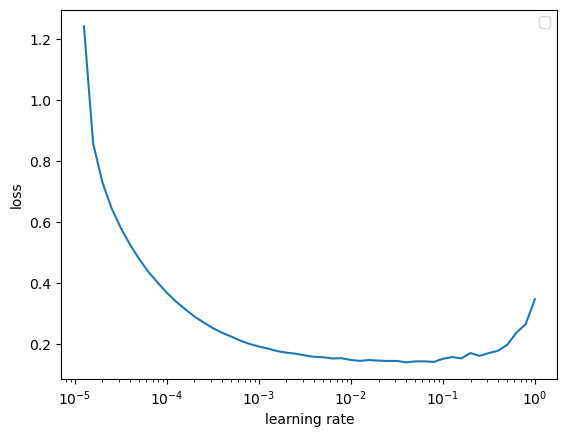

best LearningRate: 0.039810717055349734


In [32]:
tabLearningRate, tabLoss = findBestLearninRate(Net())

import matplotlib.pyplot as plt

plt.figure()
plt.plot(tabLearningRate, tabLoss)
plt.xlabel('learning rate')
plt.xscale('log')
plt.ylabel('loss')
plt.legend()

plt.show()

min_y = min(tabLoss)
min_index = tabLoss.index(min_y)

LearningRate = tabLearningRate[min_index]
print('best LearningRate:',LearningRate)

Launch the training

In [33]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LearningRate)
bestLoss_Loss, bestAccuracy_Loss = trainAlgo(train_loader,validation_loader,model,criterion,optimizer ,LearningRate)

new best model
Epoch 2 - Loss: 0.3840 - Accuracy: 0.8675 - Time: 31.07 seconds - Val Loss: 0.2848 - Val Accuracy: 0.8968 - Time: 1.48 seconds
Epoch 3 - Loss: 0.2669 - Accuracy: 0.9023 - Time: 27.78 seconds - Val Loss: 0.2877 - Val Accuracy: 0.8953 - Time: 1.58 seconds
new best model
Epoch 4 - Loss: 0.2277 - Accuracy: 0.9160 - Time: 27.38 seconds - Val Loss: 0.2586 - Val Accuracy: 0.9052 - Time: 1.68 seconds
new best model
Epoch 5 - Loss: 0.2024 - Accuracy: 0.9260 - Time: 27.62 seconds - Val Loss: 0.2575 - Val Accuracy: 0.9062 - Time: 1.37 seconds
new best model
Epoch 6 - Loss: 0.1810 - Accuracy: 0.9324 - Time: 27.19 seconds - Val Loss: 0.2492 - Val Accuracy: 0.9102 - Time: 1.54 seconds
Epoch 7 - Loss: 0.1622 - Accuracy: 0.9408 - Time: 28.86 seconds - Val Loss: 0.2636 - Val Accuracy: 0.9040 - Time: 1.63 seconds
new best model
Epoch 8 - Loss: 0.1458 - Accuracy: 0.9461 - Time: 28.40 seconds - Val Loss: 0.2413 - Val Accuracy: 0.9150 - Time: 1.44 seconds
Epoch 9 - Loss: 0.1329 - Accuracy: 0

Set the training loop

In [37]:
AccurancyByClass(model,classes,validation_loader)
    
accurancyTest(test_loader)

Accuracy for class: T-shirt/top is 86.3 %
Accuracy for class: Trouser is 98.3 %
Accuracy for class: Pullover is 79.1 %
Accuracy for class: Dress is 91.6 %
Accuracy for class: Coat  is 91.1 %
Accuracy for class: Sandal is 98.3 %
Accuracy for class: Shirt is 79.6 %
Accuracy for class: Sneaker is 95.3 %
Accuracy for class: Bag   is 98.4 %
Accuracy for class: Ankle boot is 97.6 %
Accuracy of the network on the test images: 91.24 %


#### Steps further

1. Modernize LeNet. Implement and test the following changes:
- Replace average pooling with max-pooling.
- Replace the softmax layer with ReLU.

2. Try to change the size of the LeNet style network to improve its accuracy in addition to max-pooling and ReLU. You could for example adjust:
- the convolution window size;
- the number of output channels;
- the number of convolution layers;
- the number of fully connected layers;
- the learning rates and other training details (e.g., initialization and number of epochs).

From: http://d2l.ai/chapter_convolutional-neural-networks/lenet.html